In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('./drive/MyDrive/266_project/project/')

In [3]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.0 MB/s eta 0:00:00


In [4]:
"""
Predictions
with Optuna best hyperparameters and loaded embeddings from w2v and BERT
"""

# Import packages
# Admin
import os
import time
import re
import optuna

# Data
import pandas as pd
import numpy as np
import random

# Gradients
import csv
import pickle

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, precision_recall_curve, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

# Custom modules
from global_vars import GVD, FPATH
from project_utils import calculate_metrics


#pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#plotting for embedding analysis
import plotly.graph_objs as go

#nearest neighbors
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [5]:
project_dict = [
  {'NAME':'BERT', 'W2V': False, 'FINETUNING':False, 'BASELINE': True, 'CONFIG':'bert-base-uncased'},
  {'NAME':'CNNForWord2VecBERT', 'W2V': True, 'FINETUNING':False, 'BASELINE': False, 'CONFIG':'bert-base-uncased'},
  {'NAME':'CNNForWord2VecBERTFT', 'W2V': True, 'FINETUNING':True, 'BASELINE': False, 'CONFIG':'bert-base-uncased'},
  {'NAME':'BERTweet', 'W2V': False, 'FINETUNING':False, 'BASELINE': True, 'CONFIG':'vinai/bertweet-base'},
  {'NAME':'CNNForWord2VecBERTweet', 'W2V': True, 'FINETUNING':False, 'BASELINE': False, 'CONFIG':'vinai/bertweet-base'},
  {'NAME':'CNNForWord2VecBERTweetFT', 'W2V': True, 'FINETUNING':True, 'BASELINE': False, 'CONFIG':'vinai/bertweet-base'},
  {'NAME':'ALBERT', 'W2V': False, 'FINETUNING':False, 'BASELINE': True, 'CONFIG':'albert/albert-base-v2'},
  {'NAME':'CNNForWord2VecALBERT', 'W2V': True, 'FINETUNING':False, 'BASELINE': False, 'CONFIG':'albert/albert-base-v2'},
  {'NAME':'CNNForWord2VecALBERTFT', 'W2V': True, 'FINETUNING':True, 'BASELINE': False, 'CONFIG':'albert/albert-base-v2'}
]

In [6]:
# Instantiate dataframe for each model performance result
df_BERT = pd.read_pickle(FPATH + project_dict[0]['NAME']+'_test_df.pkl')
df_CNNForWord2VecBERT = pd.read_pickle(FPATH + project_dict[1]['NAME']+'_test_df.pkl')
df_CNNForWord2VecBERTFT = pd.read_pickle(FPATH + project_dict[2]['NAME']+'_test_df.pkl')
df_BERTweet= pd.read_pickle(FPATH + project_dict[3]['NAME']+'_test_df.pkl')
df_CNNForWord2VecBERTweet = pd.read_pickle(FPATH + project_dict[4]['NAME']+'_test_df.pkl')
df_CNNForWord2VecBERTweetFT = pd.read_pickle(FPATH + project_dict[5]['NAME']+'_test_df.pkl')
df_ALBERT = pd.read_pickle(FPATH + project_dict[6]['NAME']+'_test_df.pkl')
df_CNNForWord2VecALBERT = pd.read_pickle(FPATH + project_dict[7]['NAME']+'_test_df.pkl')
df_CNNForWord2VecALBERTFT = pd.read_pickle(FPATH + project_dict[8]['NAME']+'_test_df.pkl')

# Cosine Similarity

In [7]:
def cos_sim(model_df):
  #divide df into 0 and 1 labels
  label_0 = model_df[model_df['pred'] == 0]
  label_1 = model_df[model_df['pred'] == 1]

  #further isolate into TP and FN dfs for cosine similarity
  tp = label_1[label_1['category'] == 'TP']
  tn = label_0[label_0['category'] == 'TN']
  fp = label_1[label_1['category'] == 'FP']
  fn = label_0[label_0['category'] == 'FN']


  #get embeddings for overall model, each class, and TP and TN embeddings
  embeddings = pd.DataFrame(model_df['embeddings'].tolist(), index=model_df.index)
  embeddings_0 = pd.DataFrame(label_0['embeddings'].tolist(), index=label_0.index)
  embeddings_1 = pd.DataFrame(label_1['embeddings'].tolist(), index=label_1.index)
  embeddings_tp = pd.DataFrame(tp['embeddings'].tolist(), index=tp.index)
  embeddings_tn = pd.DataFrame(tn['embeddings'].tolist(), index=tn.index)
  embeddings_fp = pd.DataFrame(fp['embeddings'].tolist(), index=fp.index)
  embeddings_fn = pd.DataFrame(fn['embeddings'].tolist(), index=fn.index)

  #calculate average embeddings
  class0_avg_embeddings = np.mean(embeddings_0, axis=0)
  class1_avg_embeddings = np.mean(embeddings_1, axis=0)
  tp_avg_embeddings = np.mean(embeddings_tp, axis=0)
  tn_avg_embeddings = np.mean(embeddings_tn, axis=0)
  fp_avg_embeddings = np.mean(embeddings_fp, axis=0)
  fn_avg_embeddings = np.mean(embeddings_fn, axis=0)

  #cosine similarities
  cosine_similarities_class0 = cosine_similarity(embeddings, [class0_avg_embeddings])
  cosine_similarities_class1 = cosine_similarity(embeddings, [class1_avg_embeddings])
  cosine_similarities_tp = cosine_similarity(embeddings_1, [tp_avg_embeddings])
  cosine_similarities_tn = cosine_similarity(embeddings_0, [tn_avg_embeddings])
  cosine_similarities_fp = cosine_similarity(embeddings_1, [fp_avg_embeddings])
  cosine_similarities_fn = cosine_similarity(embeddings_0, [fn_avg_embeddings])

  data = {
    'category': model_df['category'],
    'Cosine_similarity_opposite_class': cosine_similarities_class0.flatten(),
    'Cosine_similarity_same_class': cosine_similarities_class1.flatten()
  }

  data_class1 = {
    'category': label_1['category'],
    'Cosine_similarity_true_positive': cosine_similarities_tp.flatten(),
    'Cosine_similarity_false_positive': cosine_similarities_fp.flatten()
  }

  data_class0 = {
    'category': label_0['category'],
    'Cosine_similarity_true_negative': cosine_similarities_tn.flatten(),
    'Cosine_similarity_false_negative': cosine_similarities_fn.flatten()
  }
  df = pd.DataFrame(data)
  df_1 = pd.DataFrame(data_class1)
  df_0 = pd.DataFrame(data_class0)
  return df, df_1, df_0

In [8]:
df, df_1, df_0  = cos_sim(df_CNNForWord2VecBERTFT)
df_0

,category,Cosine_similarity_true_negative,Cosine_similarity_false_negative
1,TN,0.927036,0.880350
2,TN,0.778356,0.746330
3,TN,0.901157,0.862971
4,TN,0.911152,0.878949
5,TN,0.814346,0.773117
...,...,...,...
2949,FN,0.899675,0.869110
2951,FN,0.698185,0.762652
2956,FN,0.847709,0.824434
2961,FN,0.861949,0.861875


# Nearest Neighbors

In [9]:
def nearest_neighbors(model_df):
  #divide df into 0 and 1 labels
  label_0 = model_df[model_df['pred'] == 0]
  label_1 = model_df[model_df['pred'] == 1]

  #further isolate into TP and FN dfs for cosine similarity
  tp = label_1[label_1['category'] == 'TP']
  tn = label_0[label_0['category'] == 'TN']
  fp = label_1[label_1['category'] == 'FP']
  fn = label_0[label_0['category'] == 'FN']

  #get embeddings for each category
  embeddings_tp = pd.DataFrame(tp['embeddings'].tolist(), index=tp.index)
  embeddings_tn = pd.DataFrame(tn['embeddings'].tolist(), index=tn.index)
  embeddings_fp = pd.DataFrame(fp['embeddings'].tolist(), index=fp.index)
  embeddings_fn = pd.DataFrame(fn['embeddings'].tolist(), index=fn.index)

  #TP and TN average embeddings to be used as centroids
  tp_avg_embeddings = np.mean(embeddings_tp, axis=0)
  tn_avg_embeddings = np.mean(embeddings_tn, axis=0)

  cosine_similarities_fp = cosine_similarity(embeddings_fp, [tp_avg_embeddings])
  cosine_similarities_tp = cosine_similarity([tp_avg_embeddings], [tp_avg_embeddings])
  cosine_similarities_fn = cosine_similarity(embeddings_fn, [tn_avg_embeddings])
  cosine_similarities_tn = cosine_similarity([tn_avg_embeddings], [tn_avg_embeddings])

  # Use NearestNeighbors to find the nearest TP neighbor for each FP embedding
  num_neighbors = min(5, len(embeddings_tp))  # Number of nearest neighbors to find
  #nn = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
  nn = NearestNeighbors(n_neighbors=num_neighbors).fit(embeddings_tp)
  #nn.fit(embeddings_tp)
  distances, indices = nn.kneighbors(embeddings_fp)

  plt.scatter(cosine_similarities_tp, 0, color='red', marker='o', label='Avg. True Positive Centroid')
  plt.scatter(cosine_similarities_fp, distances.mean(axis=1))
  plt.xlabel('Cosine Similarity with Avg. True Positive Embedding')
  plt.ylabel('Average Distance to Nearest True Positive Neighbor')
  plt.title('Distance Between False Positive and True Positive Embeddings')
  plt.show()


  num_neighbors_tn = min(5, len(embeddings_tn))  # Number of nearest neighbors to find
  #nn = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
  nn_tn = NearestNeighbors(n_neighbors=num_neighbors_tn).fit(embeddings_tn)
  #nn.fit(embeddings_tp)
  distances_tn, indices_tn = nn_tn.kneighbors(embeddings_fn)

  plt.scatter(cosine_similarities_tn, 0, color='red', marker='o', label='Avg. True Negative Centroid')
  plt.scatter(cosine_similarities_fn, distances_tn.mean(axis=1))
  plt.xlabel('Cosine Similarity with Avg. True Negative Embedding')
  plt.ylabel('Average Distance to Nearest True Negative Neighbor')
  plt.title('Distance Between False Negative and True Negative Embeddings')
  plt.show()

  #print(embeddings_tp.index.tolist())
  # Plot the nearest neighbors
  #plt.figure(figsize=(10, 8))
  #for i in range(len(embeddings_fp)):
  #    neighbors = embeddings_tp[indices[i]]
  #    plt.scatter(neighbors[:, 0], neighbors[:, 1], color='blue', alpha=0.5)
  #    plt.scatter(embeddings_fp[i, 0], embeddings_fp[i, 1], color='red', marker='x', label='FP Embedding')
  #plt.scatter(centroid[0], centroid[1], color='green', marker='o', label='TP Centroid')
  #plt.xlabel('Dimension 1')
  #plt.ylabel('Dimension 2')
  #plt.title('Nearest Neighbors of FP Embeddings')
  #plt.legend()
  #plt.grid(True)
  #plt.show()

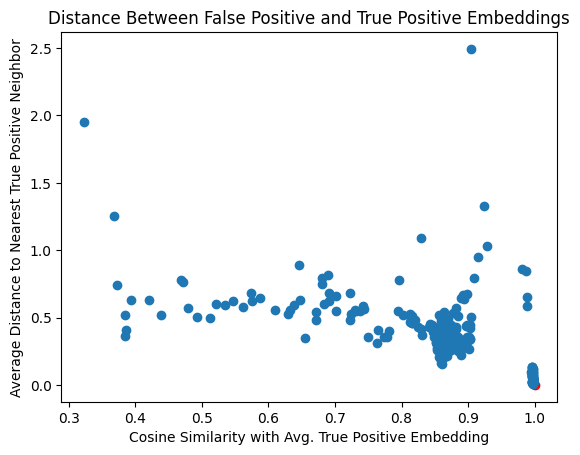

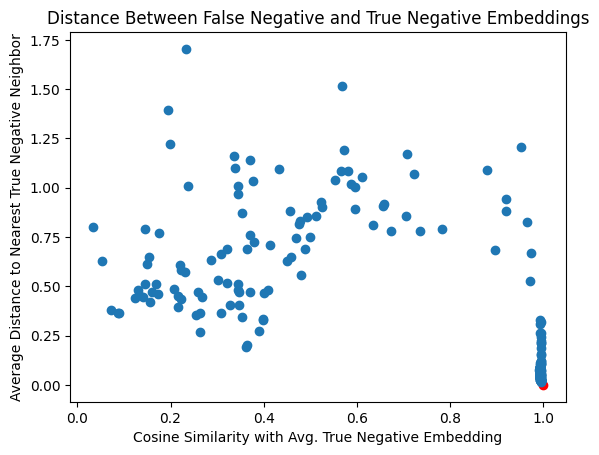

In [10]:
nearest_neighbors(df_BERT)

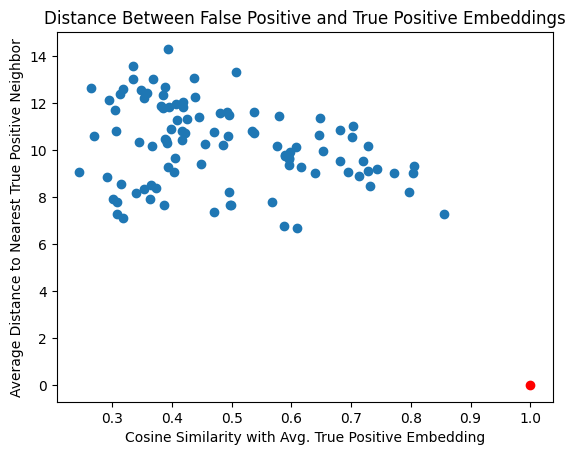

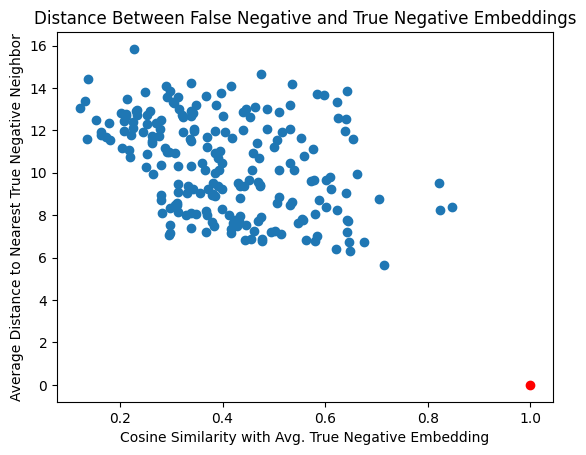

In [11]:
nearest_neighbors(df_CNNForWord2VecBERT)


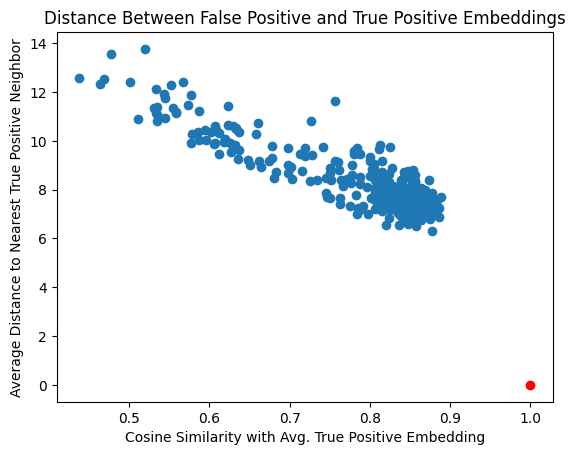

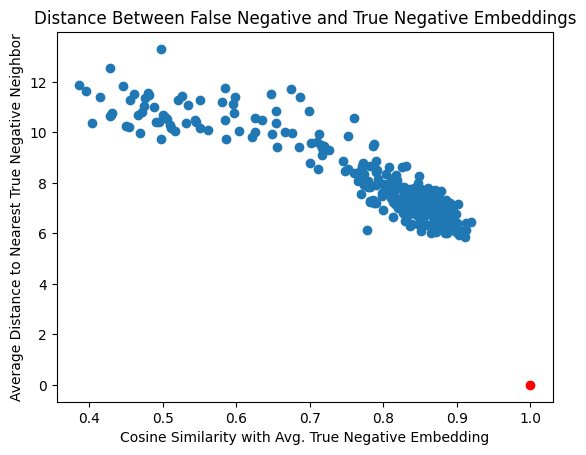

In [12]:
nearest_neighbors(df_CNNForWord2VecBERTFT)


In [13]:
#nearest_neighbors(df_BERTweet)


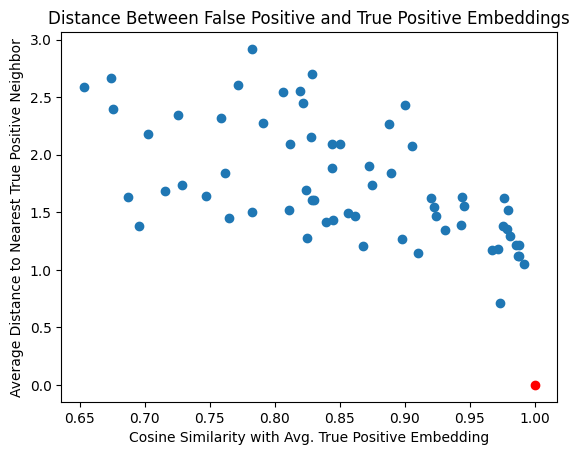

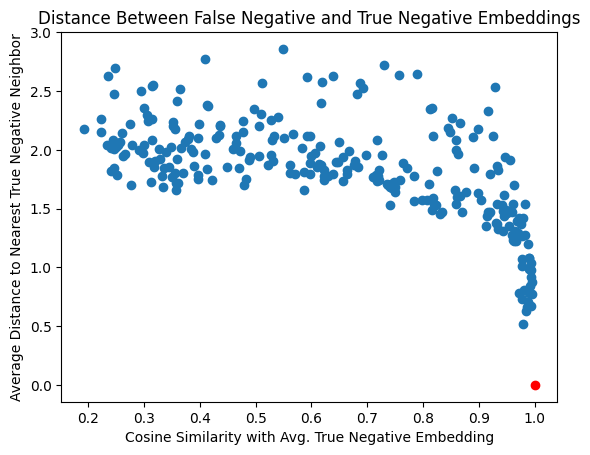

In [14]:
nearest_neighbors(df_CNNForWord2VecBERTweet)


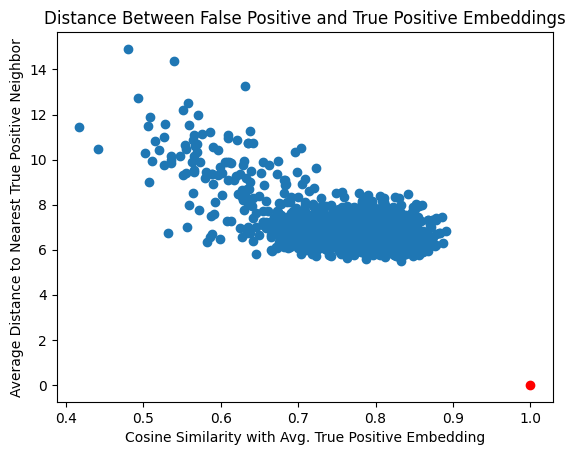

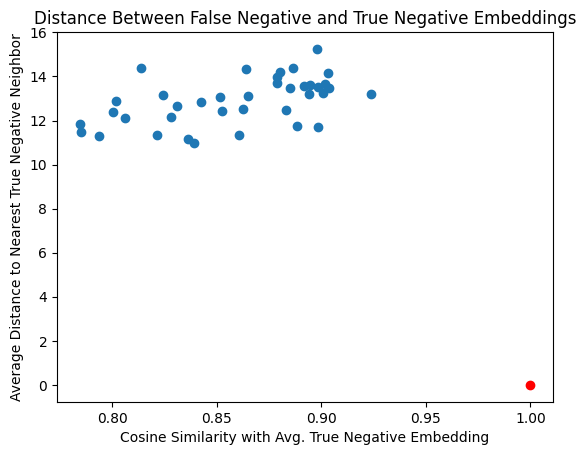

In [15]:
nearest_neighbors(df_CNNForWord2VecBERTweetFT)


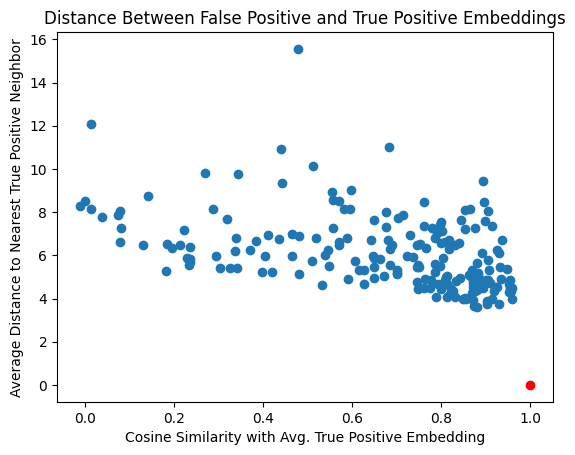

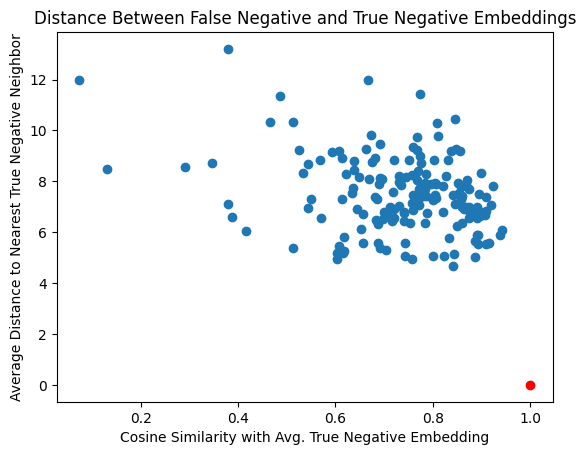

In [16]:
nearest_neighbors(df_ALBERT)


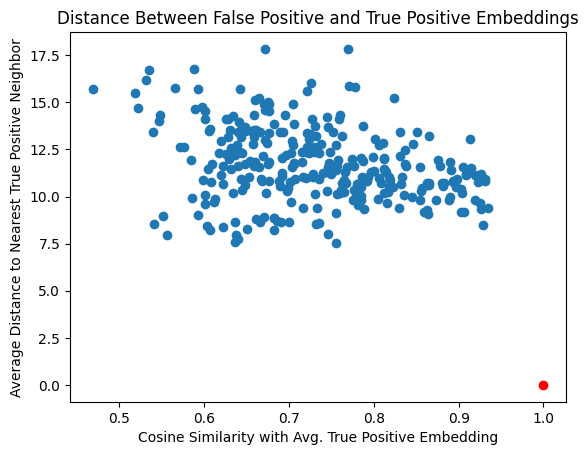

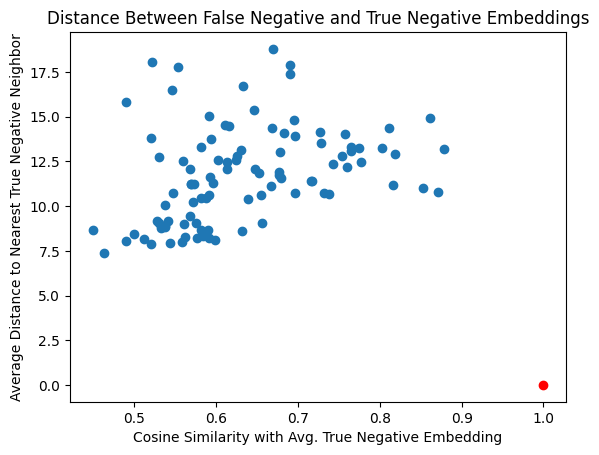

In [17]:
nearest_neighbors(df_CNNForWord2VecALBERT)


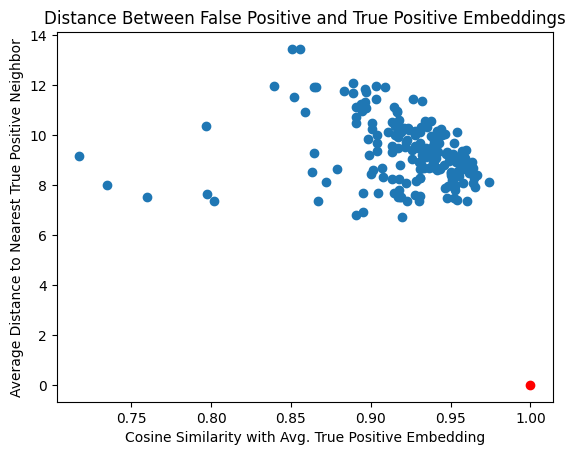

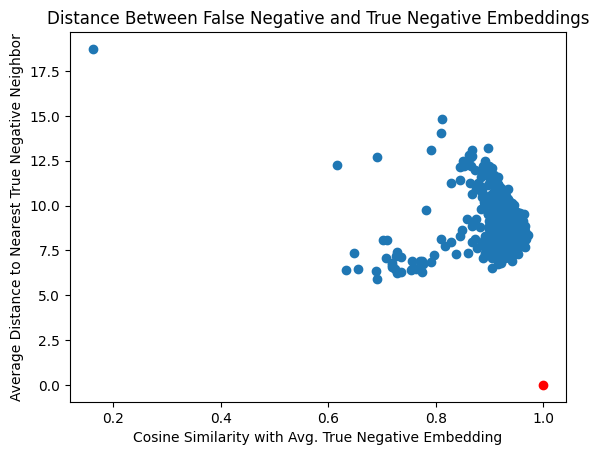

In [18]:
nearest_neighbors(df_CNNForWord2VecALBERTFT)


# PCA

In [7]:
def embeddings_analysis(model_df):
  #divide df into 0 and 1 labels
  label_0 = model_df[model_df['pred'] == 0]
  label_1 = model_df[model_df['pred'] == 1]

  #isolate embeddings for each label into its own data frame
  embeddings_0 = pd.DataFrame(label_0['embeddings'].tolist(), index=label_0.index)
  embeddings_1 = pd.DataFrame(label_1['embeddings'].tolist(), index=label_1.index)

  # Apply PCA to reduce dimensionality separately for label 0 and label 1
  pca_label_0 = PCA(n_components=3).fit_transform(embeddings_0)
  pca_label_1 = PCA(n_components=3).fit_transform(embeddings_1)


  # Create DataFrame for plotting
  df_label_0 = pd.DataFrame({
      'PC1': pca_label_0[:, 0],
      'PC2': pca_label_0[:, 1],
      'PC3': pca_label_0[:, 2],
      'Label': 0,  # Set label to 0
      'Category': label_0['category']
  })

  df_label_1 = pd.DataFrame({
      'PC1': pca_label_1[:, 0],
      'PC2': pca_label_1[:, 1],
      'PC3': pca_label_1[:, 2],
      'Label': 1,  # Set label to 1
      'Category': label_1['category']
  })

  # Plot label 0
  fig = go.Figure()

  for category in np.unique(df_label_0['Category']):
      subset = df_label_0[df_label_0['Category'] == category]
      fig.add_trace(go.Scatter3d(
          x=subset['PC1'],
          y=subset['PC2'],
          z=subset['PC3'],
          mode='markers',
          name=f'Category {category}'
      ))

  fig.update_layout(
      scene=dict(
          xaxis=dict(title='Principal Component 1'),
          yaxis=dict(title='Principal Component 2'),
          zaxis=dict(title='Principal Component 3')
      ),
      title='PCA Visualization of Pooled Embeddings for Label 0'
  )
  fig.show()

  # Plot label 1
  fig = go.Figure()

  for category in np.unique(df_label_1['Category']):
      subset = df_label_1[df_label_1['Category'] == category]
      fig.add_trace(go.Scatter3d(
          x=subset['PC1'],
          y=subset['PC2'],
          z=subset['PC3'],
          mode='markers',
          name=f'Category {category}'
      ))

  fig.update_layout(
      scene=dict(
          xaxis=dict(title='Principal Component 1'),
          yaxis=dict(title='Principal Component 2'),
          zaxis=dict(title='Principal Component 3')
      ),
      title='PCA Visualization of Pooled Embeddings for Label 1'
  )
  fig.show()

In [8]:
embeddings_analysis(df_BERT)

In [21]:
embeddings_analysis(df_CNNForWord2VecBERT)

In [22]:
embeddings_analysis(df_CNNForWord2VecBERTFT)

In [23]:
embeddings_analysis(df_BERTweet)

In [24]:
embeddings_analysis(df_CNNForWord2VecBERTweet)

In [25]:
embeddings_analysis(df_CNNForWord2VecBERTweetFT)

In [26]:
embeddings_analysis(df_ALBERT)

In [27]:
embeddings_analysis(df_CNNForWord2VecALBERT)

In [28]:
embeddings_analysis(df_CNNForWord2VecALBERTFT)